---
# Exercício Pré-processamento (car dataset) - encoder, cross-validation, pipeline 
---
**Machine Learning em Projetos (Erick Muzart e Fernando Melo)**   
Tópicos:
- encoder  
- cross-validation  
- pipeline  

**Fonte dados:**
Car Evaluation Data Set: https://archive.ics.uci.edu/ml/datasets/Car+Evaluation


### **Descrição do projeto de machine learning**
Antes de escrever qualquer código, precisamos entender o problema que queremos resolver e fazer uma descrição eficiente do projeto, visando a comunicação  simples e rápida do objetivo do projeto para técnicos, gestores e colaboradores.  
  
**1- Descrição do problema ou tarefa:**  
Prever a avaliação de compra de um determinado carro com base nas suas características.  
**2- Descrição da solução de IA:**   
Treinamento supervisionado de modelo de classificação da avaliação de compra do carro em 4 classes: inaceitável, aceitável, bom e muito bom (unacc, acc, good, v-good), com base nas características do veículo.   
**3- Fonte de dados:**  
Car Evaluation Data Set: https://archive.ics.uci.edu/ml/datasets/Car+Evaluation   
**4- Variáveis independentes (preditoras ou "features"):**  
'buying', maint', 'doors', 'persons', 'lug_boot', 'safety'.     
**5- Variável dependente (resposta ou "target"):**   
car (unacc, acc, good, v-good)  

----------------------------------------------------------- 

## Carregar bibliotecas de código

In [41]:
# Importar bibliotecas
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics

## Análise exploratória do dados

In [2]:
# Ler os dados
# Pode-se usar diretamente a função read_csv() do pandas para ler o dataset remoto
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', header=None)
df.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [3]:
# Atribuir nomes mais explicativos para as colunas do dataset
df.columns = ['buying','maint', 'doors', 'persons', 'lug_boot', 'safety', 'car']
# Mostrar as dimensões do dataset
print('Dimensões do dataset: ', df.shape)
# Mostrar as primeiras linhas do dataset
df.tail()

Dimensões do dataset:  (1728, 7)


,buying,maint,doors,persons,lug_boot,safety,car
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good
1727,low,low,5more,more,big,high,vgood


unacc    1210
acc       384
good       69
vgood      65
Name: car, dtype: int64


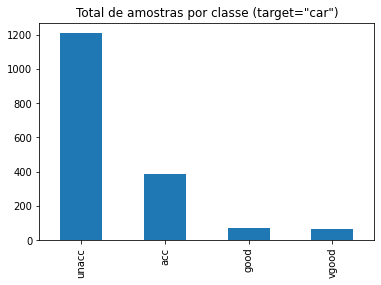

In [4]:
# Mostra o total de amostras por classe da variável dependente (target)
print(df.car.value_counts())
df.car.value_counts().plot(kind='bar', title='Total de amostras por classe (target="car")');

Podemos observar acima que:
- As classes estão bastante desbalanceadas.

**Já podemos treinar um primeiro modelo?**

**Por que deu erro ?**  
Todas os dados de treinamento precisam ser obrigatoriamente **números**.  
Portanto, precisamos codificar todos os caracteres em números. 

## Pipeline com OneHotEncoder e cross-validation

In [13]:
# Importar make_pipeline, StandardScaler, LogisticRegression, cross_val_score, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [6]:
# Atribuir variáveis independentes para X
X = df.iloc[:,:-1]
# Atribuir variável dependente para y
y = df['car']

In [57]:
# Criar pipeline com os passos StandardScaler() e LogisticRegression(), usando make_pipeline.
pipe = make_pipeline(OneHotEncoder(), LogisticRegression(max_iter=1000))
pipe

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [58]:
# Fazer cross validation 10 folds do pipeline e tire a média dos scores
cross_val_score(pipe, X, y, cv=10, scoring='accuracy').mean()

0.8333075682215352

In [59]:
# O pipeline pode ser treinado e usado como qualquer outro modelo
# e evita vazamento de dados (data leakage) de teste para os dados de treino.

# Dividir dados em treino e teste (80/20) com stratify, pois as classes estão desbalanceadas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# treinar o pipeline com .fit
pipe.fit(X_train, y_train)
# verificar o score do pipeline com .score
pipe.score(X_test, y_test)


0.9017341040462428

In [60]:
# Verificar o f1_score do modelo, quando as classes estão desbalenceadas, lembrando de aplicar o get_dummies encoder nos dados de teste
metrics.f1_score(y_test, pipe.predict(X_test), average='weighted')

0.9005131108289443

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


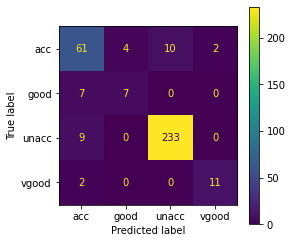

In [61]:
# Mostrar a Matriz de Confusão, lembrando de aplicar o get_dummies encoder nos dados de teste
fig, ax = plt.subplots(figsize=(4,4))
plot_confusion_matrix(pipe, X_test, y_test, ax=ax, values_format='d');

In [37]:
# Criar novos dados para teste contendo 2 linhas do X_test (apenas para testar predição com o modelo pipeline treinado acima)
novo_X = X_test[0:2]
novo_X

,buying,maint,doors,persons,lug_boot,safety
1696,low,low,4,more,med,med
906,med,vhigh,3,4,big,low


In [38]:
# Faz predição com o modelo do pipeline treinado acima.
pipe.predict(X_test[0:2])

array(['good', 'unacc'], dtype=object)

### pipeline tem algumas vantagens:

1- Seu arquivo de treinamento permanece o mesmo e não vai crescer por causa do one-hot encoding.  
2- Na predição de novos dados, não é necessário fazer pandas dummies no novo arquivo. Também evita eventuais problemas caso os novos dados não tenham todas as categorias que existem nos dados de treinamento. As dimensões do novo dataset será diferente e vai dar erro.  
3- É possível fazer grid search para os parâmetros de pré-processamento e os parâmetros do modelo.  
